In [ ]:
import csv

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [2]:
dataset = 'keypoint.csv'
model_save_path = 'keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'keypoint_classifier/keypoint_classifier.tflite'

In [16]:
# Change training classes if necessary
NUM_CLASSES = 8

In [17]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [18]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([1595, 1663, 1510,  672,  164,  257,  139,  190]))


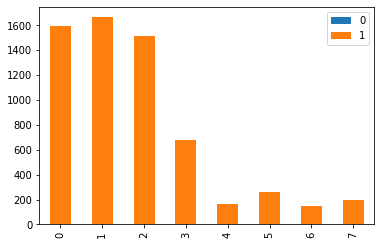

In [21]:
# Classes count
counts = np.unique(y_dataset, return_counts=True)
df = pd.DataFrame(counts)
df.T.plot(kind="bar", stacked=True)
print(counts)

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [23]:

model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_3 (Dropout)         (None, 42)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                1376      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 8)                

In [24]:

# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=50, verbose=1)

In [25]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
36/73 [=============>................] - ETA: 0s - loss: 1.9806 - accuracy: 0.2144 
Epoch 1: val_loss improved from inf to 1.43326, saving model to keypoint_classifier/keypoint_classifier.hdf5
73/73 [==============================] - 1s 4ms/step - loss: 1.8165 - accuracy: 0.3389 - val_loss: 1.4333 - val_accuracy: 0.5853
Epoch 2/1000
59/73 [=======================>......] - ETA: 0s - loss: 1.1936 - accuracy: 0.6311
Epoch 2: val_loss improved from 1.43326 to 0.81885, saving model to keypoint_classifier/keypoint_classifier.hdf5
73/73 [==============================] - 0s 3ms/step - loss: 1.1302 - accuracy: 0.6579 - val_loss: 0.8188 - val_accuracy: 0.7636
Epoch 3/1000
41/73 [===============>..............] - ETA: 0s - loss: 0.7245 - accuracy: 0.7782
Epoch 3: val_loss improved from 0.81885 to 0.47952, saving model to keypoint_classifier/keypoint_classifier.hdf5
73/73 [==============================] - 0s 2ms/step - loss: 0.6561 - accuracy: 0.8050 - val_loss: 0.4795 - val_accura

In [27]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [28]:
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=64)

25/25 [==============================] - 0s 1ms/step - loss: 0.0026 - accuracy: 0.9994


In [29]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[1.00000000e+00 6.77988698e-13 1.67669497e-19 5.62215207e-16
 4.21220188e-13 1.32736465e-30 6.24659200e-28 4.59148483e-24]
0


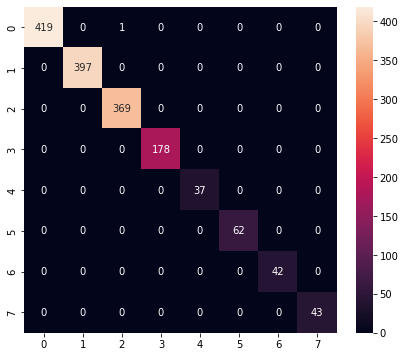

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       420
           1       1.00      1.00      1.00       397
           2       1.00      1.00      1.00       369
           3       1.00      1.00      1.00       178
           4       1.00      1.00      1.00        37
           5       1.00      1.00      1.00        62
           6       1.00      1.00      1.00        42
           7       1.00      1.00      1.00        43

    accuracy                           1.00      1548
   macro avg       1.00      1.00      1.00      1548
weighted avg       1.00      1.00      1.00      1548



In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [31]:
model.save(model_save_path, include_optimizer=False)

In [32]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpqvuuf74v/assets


7744

In [33]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [34]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [35]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [36]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 326 µs, sys: 32 µs, total: 358 µs
Wall time: 246 µs


In [37]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.0000000e+00 7.4015745e-13 1.0213718e-19 7.7495108e-16 5.1720715e-13
 1.2744704e-30 7.8226180e-28 5.3863683e-24]
0


In [38]:
!zip -r model.zip keypoint_classifier  

  adding: keypoint_classifier/ (stored 0%)
  adding: keypoint_classifier/keypoint_classifier.tflite (deflated 21%)
  adding: keypoint_classifier/keypoint_classifier.hdf5 (deflated 61%)


In [39]:
%load_ext tensorboard
from tensorboard.plugins.hparams import api as hp

In [40]:
# Init parameters to tune
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([16, 32, 64]))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([8, 16, 32]))
HP_NUM_UNITS_3 = hp.HParam('num_units_3', hp.Discrete([8, 16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.0, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

In [41]:
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS_1,HP_NUM_UNITS_2,HP_NUM_UNITS_3, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [42]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=15, verbose=1)

In [43]:
def train_test_model(hparams):

  model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS_1], activation='relu'),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS_2], activation='relu'),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS_3], activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
  
  model.compile(
    optimizer=hparams[HP_OPTIMIZER],
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
  
  cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)

  model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[
               cp_callback,
               es_callback,
               ]
  ) 

  # Load model with best accuracy
  model = tf.keras.models.load_model(model_save_path)

  _, accuracy = model.evaluate(X_test, y_test)
  return accuracy

def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [ ]:
session_num = 0

for num_units_1 in HP_NUM_UNITS_1.domain.values:
  for num_units_2 in HP_NUM_UNITS_2.domain.values:
    for num_units_3 in HP_NUM_UNITS_3.domain.values:
      for dropout_rate in np.arange(HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value, 0.1):
        for optimizer in HP_OPTIMIZER.domain.values:
          hparams = {
              HP_NUM_UNITS_1: num_units_1,
              HP_NUM_UNITS_2: num_units_2,
              HP_NUM_UNITS_3: num_units_3,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
          }
          run_name = "run-%d" % session_num
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          run('logs/hparam_tuning/' + run_name, hparams)
          session_num += 1

--- Starting trial: run-0
{'num_units_1': 16, 'num_units_2': 8, 'num_units_3': 8, 'dropout': 0.0, 'optimizer': 'adam'}
Epoch 1/50
65/73 [=========================>....] - ETA: 0s - loss: 1.9640 - accuracy: 0.2952
Epoch 1: val_loss improved from inf to 1.76175, saving model to keypoint_classifier/keypoint_classifier.hdf5
73/73 [==============================] - 1s 4ms/step - loss: 1.9477 - accuracy: 0.3042 - val_loss: 1.7617 - val_accuracy: 0.4018
Epoch 2/50
72/73 [============================>.] - ETA: 0s - loss: 1.5448 - accuracy: 0.4692
Epoch 2: val_loss improved from 1.76175 to 1.33000, saving model to keypoint_classifier/keypoint_classifier.hdf5
73/73 [==============================] - 0s 2ms/step - loss: 1.5432 - accuracy: 0.4690 - val_loss: 1.3300 - val_accuracy: 0.5078
Epoch 3/50
39/73 [===============>..............] - ETA: 0s - loss: 1.2656 - accuracy: 0.5084
Epoch 3: val_loss improved from 1.33000 to 1.03894, saving model to keypoint_classifier/keypoint_classifier.hdf5
73/73 

In [ ]:
%tensorboard --logdir logs/hparam_tuning